In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()


In [7]:
data_tranforms ={
    'train':transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir ='/Users/saibhargavmandava/Documents/bhushanGit/TransferLearning-PyTorch-/hymenoptera_data'
image_datasets ={
    x:datasets.ImageFolder(os.path.join(data_dir,x),data_tranforms[x]) for x in ['train','val']
}
dataloaders ={
    x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4) for x in ['train','val']
}
dataset_sizes ={x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"using device {device}")

using device mps


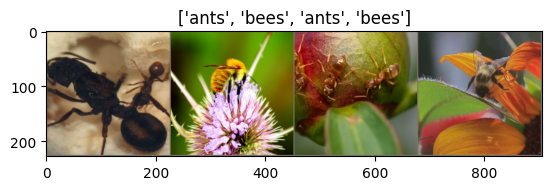

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def train_model(model ,criterion,optimizer ,scheduler,num_epochs=25):
    since =time.time() # evaluating the time 
    #creating a temporary directory for tracking our best parameters and model performance
    with TemporaryDirectory() as tempdir:
        best_model_params_paths =os.path.join(tempdir,'best_model_params.pt')#saving the best model parameters in the temporary directory in the path best_model_params.pt
        torch.save(model.state_dict(),best_model_params_paths)#saving the model paranmeters if model dosent imporve based on the changing learning rate
        best_acc =0.0 # starting our best accuracy with 0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')#printing our epoch number
            print('-'*10)# printing a line of 10 dashes
            for phase in ['train','val']:
                if phase == 'train':
                    model.train()#setting our model mode to train
                else:
                    model.eval()#setting our model to eval state where we wont do no backpropagation
                running_loss =0.0#starting our running loss with 0
                running_corrects =0#starting our running corrects with 0
                for inputs,labels in dataloaders[phase]:
                    inputs =inputs.to(device)#devic mps becuse am using mac
                    labels =labels.to(device)
                    optimizer.zero_grad()#making our initial gradiants to zero to avoid all the conflicts
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs =model(inputs)#getting our outputs
                        loss =criterion(outputs,labels)#calucalating the loss
                        _,preds =torch.max(outputs,1)#getting the maximum value of the outputs
                        if phase =='train': #if this phase is train we wii go with the back propagation 
                            loss.backward()
                            optimizer.step()
                        running_loss +=loss.item()*inputs.size(0)#we are getting cuurent loss and multiplying with the size of the inputs
                        running_corrects +=torch.sum(preds ==labels.data)#getting the sum of the correct predictions comparing if they are labeld correctly
                    if phase == 'train':
                        scheduler.step()#stepping our scheduler for the learning rate
                    epoch_loss =running_loss/dataset_sizes[phase]
                    epoch_acc =running_corrects.float()/dataset_sizes[phase]
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                    if phase =='val' and epoch_acc >best_acc:
                        best_acc =epoch_acc
                        torch.save(model.state_dict(),best_model_params_paths)
                    print()
        time_elapsed =time.time()-since
        print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        model.load_state_dict(torch.load(best_model_params_paths))#loading the best model parameters
        return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/saibhargavmandava/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0135 Acc: 0.0041

train Loss: 0.0286 Acc: 0.0041

train Loss: 0.0430 Acc: 0.0082

train Loss: 0.0577 Acc: 0.0123

train Loss: 0.0663 Acc: 0.0246

train Loss: 0.0747 Acc: 0.0410

train Loss: 0.0849 Acc: 0.0533

train Loss: 0.0946 Acc: 0.0656

train Loss: 0.1031 Acc: 0.0779

train Loss: 0.1141 Acc: 0.0902

train Loss: 0.1212 Acc: 0.1066

train Loss: 0.1314 Acc: 0.1148

train Loss: 0.1452 Acc: 0.1230

train Loss: 0.1541 Acc: 0.1352

train Loss: 0.1608 Acc: 0.1516

train Loss: 0.1743 Acc: 0.1639

train Loss: 0.1846 Acc: 0.1762

train Loss: 0.1960 Acc: 0.1885

train Loss: 0.2072 Acc: 0.2008

train Loss: 0.2175 Acc: 0.2131

train Loss: 0.2288 Acc: 0.2172

train Loss: 0.2397 Acc: 0.2254

train Loss: 0.2478 Acc: 0.2377

train Loss: 0.2574 Acc: 0.2500

train Loss: 0.2658 Acc: 0.2623

train Loss: 0.2734 Acc: 0.2787

train Loss: 0.2829 Acc: 0.2951

train Loss: 0.2937 Acc: 0.3074

train Loss: 0.3038 Acc: 0.3197

train Loss: 0.3144 Acc: 0.3320

train Loss: 0.3237

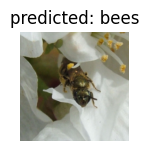

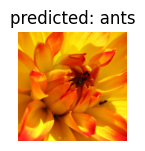

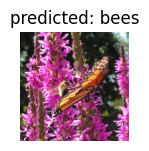

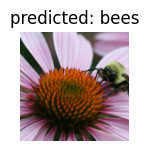

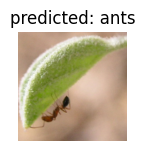

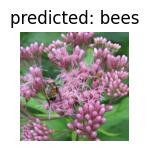

In [23]:
visualize_model(model_ft)

In [6]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False
num_ftrs =model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)
model_conv =model_conv.to(device)
criterion =nn.CrossEntropyLoss()
optimizer_conv =optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler =lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)

NameError: name 'device' is not defined

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0078 Acc: 0.0164

train Loss: 0.0194 Acc: 0.0246

train Loss: 0.0288 Acc: 0.0369

train Loss: 0.0401 Acc: 0.0451

train Loss: 0.0499 Acc: 0.0574

train Loss: 0.0629 Acc: 0.0697

train Loss: 0.0755 Acc: 0.0779

train Loss: 0.0889 Acc: 0.0820

train Loss: 0.0985 Acc: 0.0943

train Loss: 0.1130 Acc: 0.1025

train Loss: 0.1347 Acc: 0.1066

train Loss: 0.1458 Acc: 0.1148

train Loss: 0.1595 Acc: 0.1189

train Loss: 0.1702 Acc: 0.1270

train Loss: 0.1821 Acc: 0.1352

train Loss: 0.1939 Acc: 0.1434

train Loss: 0.2054 Acc: 0.1557

train Loss: 0.2160 Acc: 0.1680

train Loss: 0.2268 Acc: 0.1803

train Loss: 0.2367 Acc: 0.1926

train Loss: 0.2473 Acc: 0.2008

train Loss: 0.2575 Acc: 0.2131

train Loss: 0.2707 Acc: 0.2213

train Loss: 0.2828 Acc: 0.2336

train Loss: 0.2965 Acc: 0.2336

train Loss: 0.3051 Acc: 0.2500

train Loss: 0.3172 Acc: 0.2582

train Loss: 0.3282 Acc: 0.2705

train Loss: 0.3381 Acc: 0.2828

train Loss: 0.3483 Acc: 0.2951

train Loss: 0.3575

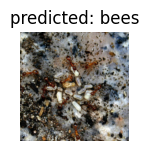

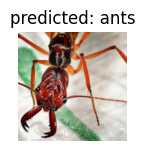

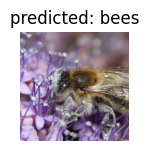

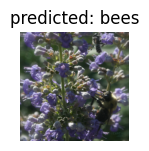

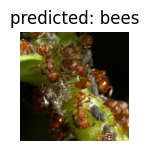

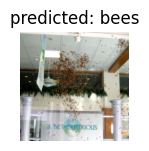

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [1]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_tranforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [3]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

NameError: name 'model_conv' is not defined